<a href="https://colab.research.google.com/github/dcheung11/chess.com-data-analysis-python/blob/main/chess_com_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chess Game Data Fetching

**Imports**

In [90]:
!pip install chess.com

from chessdotcom import get_leaderboards, get_player_stats, get_player_game_archives
import pprint
import requests
import numpy as np
# printer = pprint.PrettyPrinter()
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Get archived game data using chess.com API**

In [2]:
# Get archived games
username="damedolla5"
def get_monthly_games(archive):
    response = requests.get(archive)
    if response.status_code == 200:
        data = response.json()
        return data['games']
        # do something with the data here
    else:
        print(f'Request failed with status code {response.status_code}')
        return

# Get archives from last 12 months
def get_game_archives(username,timeclass):
    all_games = []
    data = get_player_game_archives(username).json
    for archive in data["archives"][-12:]:
        monthly_games = get_monthly_games(archive)
        all_games.extend(monthly_games)
    bullet_games = [game for game in all_games if game['time_class'] == timeclass]
    return bullet_games
data = get_game_archives(username, "bullet")


# Data Engineering

**Helper/Lambda Functions for DataFrame Engineering**

In [118]:
def get_end_date_from_pgn(pgn):
  pgn_date = pgn.split("\n")[18]
  return pgn_date.split("\"")[1]


def get_end_time_from_pgn(pgn):
  pgn_time = pgn.split("\n")[19]
  return pgn_time[10:-2]


import re
def get_opening_from_pgn(pgn):

  pgn_opening = pgn.split("\n")[10]
  opening_url = pgn_opening.split("\"")[1]
  url_prefix = "https://www.chess.com/openings/"
  opening = opening_url[len(url_prefix):]

  return opening[:12]

def parse_game_info(white,black,username):
  draw_types = ["timevsinsufficient","repetition","stalemate", "insufficient", "agreed"]
  if white['username'] == username:
    colour = "white"
    result = white["result"] 
    method = black["result"] 
    if result in draw_types:
      method=result
      result = "draw"
    elif result != "win":
      method=result
      result = "lose"
    player_rating = white["rating"]
    opp_rating = black["rating"]
  else:
    colour = "black"
    result = black["result"]
    method = white["result"] 
    if result in draw_types:
      method=result
      result = "draw"
    elif result != "win":
      method=result
      result = "lose"
    player_rating = black["rating"]
    opp_rating = white["rating"]
  return result,colour,player_rating,opp_rating,method

def parse_end_date(end_date):
  if len(end_date.split(".")) != 3:
    return [None,None,None]
  return end_date.split(".")

def parse_end_time(end_time):
  if len(end_time.split(":")) != 3:
    return [None,None,None]
  return end_time.split(":")



**DataFrame preprocessing**

In [170]:
df = pd.DataFrame.from_records(data)
df["end_date"] = df.apply(lambda x: get_end_date_from_pgn(x['pgn']), axis=1)
df["end_time"] = df.apply(lambda x: get_end_time_from_pgn(x['pgn']), axis=1)
df["opening"] = df.apply(lambda x: get_opening_from_pgn(x['pgn']), axis=1)
df["result"] = df.apply(lambda x: parse_game_info(x['white'],x['black'],username)[0], axis=1)
df["method"] = df.apply(lambda x: parse_game_info(x['white'],x['black'],username)[4], axis=1)
df["colour"] = df.apply(lambda x: parse_game_info(x['white'],x['black'],username)[1], axis=1)
df["player_rating"] = df.apply(lambda x: parse_game_info(x['white'],x['black'],username)[2], axis=1)
df["opponent_rating"] = df.apply(lambda x: parse_game_info(x['white'],x['black'],username)[3], axis=1)
# df = df.drop([ "url", "time_control", "tcn", "uuid", "initial_setup", "fen", "accuracies", "tournament", "rated", "rules"],axis=1)

df = df.drop(["pgn","white","black", "url", "time_control", "tcn", "uuid", "initial_setup", "fen", "accuracies", "tournament", "rated", "rules"],axis=1)
df["year"] = df.apply(lambda x: parse_end_date(x['end_date'])[0], axis=1)
df["month"] = df.apply(lambda x: parse_end_date(x['end_date'])[1], axis=1)
df["day"] = df.apply(lambda x: parse_end_date(x['end_date'])[2], axis=1)

df["hour"] = df.apply(lambda x: parse_end_time(x['end_time'])[0], axis=1)
df["minute"] = df.apply(lambda x: parse_end_time(x['end_time'])[1], axis=1)

df = df.drop(["end_date"] ,axis=1)
df = df.dropna()
df["year"] = df.apply(lambda x: int((x['year'])), axis=1)
df["month"] = df.apply(lambda x: int((x['month'])), axis=1)
df["day"] = df.apply(lambda x: int((x['day'])), axis=1)
df["hour"] = df.apply(lambda x: int((x['hour'])), axis=1)
df["minute"] = df.apply(lambda x: int((x['minute'])), axis=1)

df.tail()

,end_time,time_class,opening,result,method,colour,player_rating,opponent_rating,year,month,day,hour,minute
11830,15:04:17,bullet,English-Open,win,checkmated,black,2060,2045,2023,5,25,15,4
11831,15:06:32,bullet,Bishops-Open,lose,timeout,black,2052,2047,2023,5,25,15,6
11832,15:08:48,bullet,Vant-Kruijs-,draw,timevsinsufficient,white,2054,2149,2023,5,25,15,8
11833,15:10:54,bullet,Mieses-Openi,lose,timeout,black,2047,2108,2023,5,25,15,10
11834,15:12:15,bullet,Italian-Game,lose,abandoned,white,2039,2054,2023,5,25,15,12


# Data Analysis

Text(0.5, 1.0, 'Win/Loss/Draw')

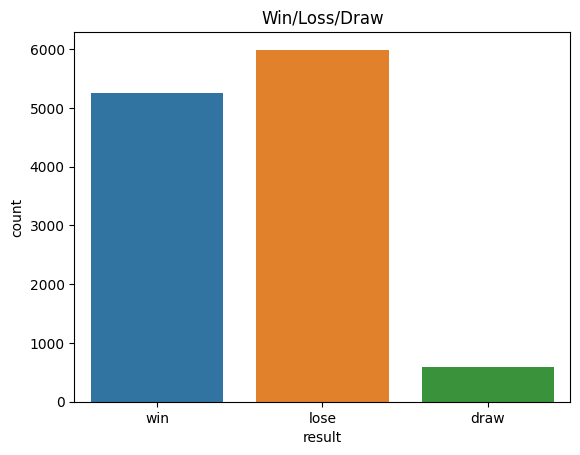

In [93]:
sns.countplot(x='result', data=df)
plt.title("Win/Loss/Draw")

# Opening Analysis

**Opening vs Result Analysis**

Top 15 Openings

In [131]:
df['opening'].value_counts().head(15)

Sicilian-Def    1289
Queens-Pawn-     830
French-Defen     795
Giuoco-Piano     681
Scandinavian     669
Caro-Kann-De     632
Queens-Gambi     626
Kings-Pawn-O     486
Italian-Game     471
Scotch-Game-     433
Modern-Defen     392
Nimzowitsch-     375
Pirc-Defense     313
Ruy-Lopez-Op     292
English-Open     280
Name: opening, dtype: int64

Opening vs Result

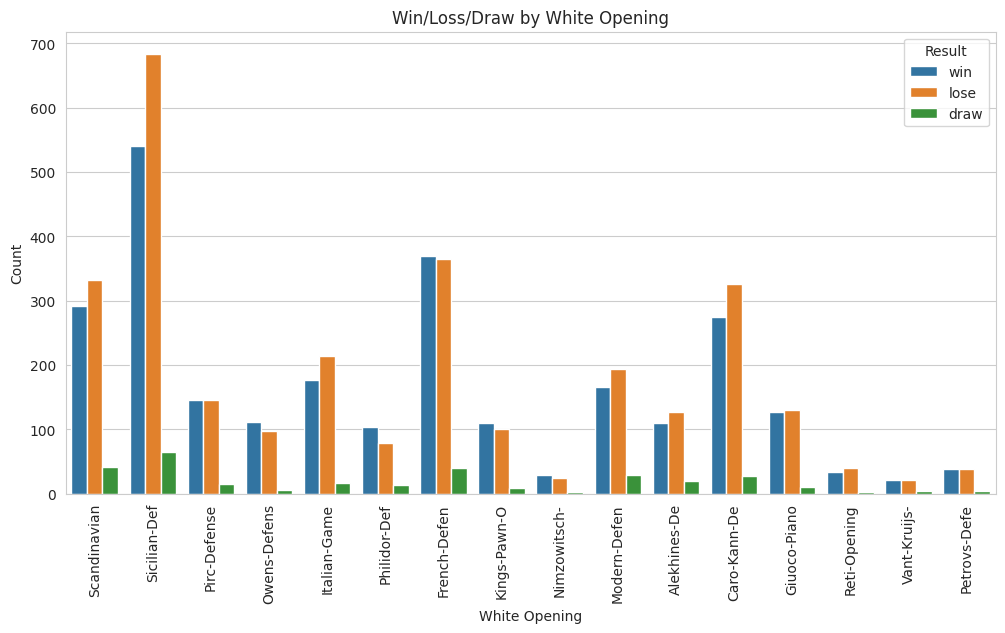

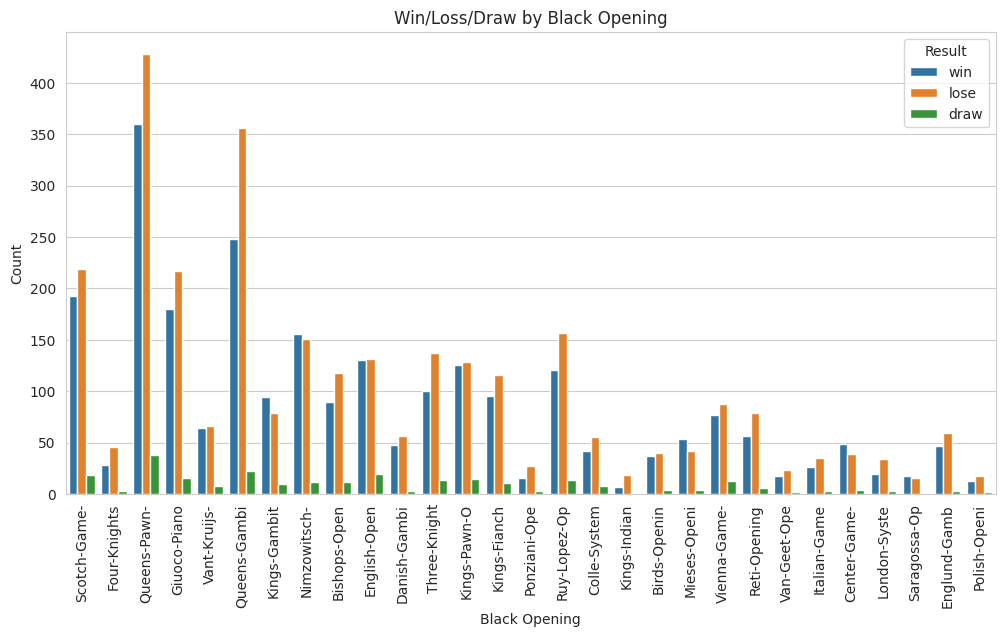

In [198]:

threshold = 25  # Adjust the threshold value as needed

# Filter the DataFrame for each color
df_white = df[df['colour'] == 'white']
df_black = df[df['colour'] == 'black']

# Calculate the counts for white openings
white_counts = df_white['opening'].value_counts()

# Filter the white openings based on the threshold
white_openings = white_counts[white_counts >= threshold].index

# Filter the white DataFrame based on the selected openings
df_white_filtered = df_white[df_white['opening'].isin(white_openings)]

# Plot for white openings
plt.figure(figsize=(12, 6))
sns.countplot(data=df_white_filtered, x='opening', hue='result')
plt.xlabel('White Opening')
plt.ylabel('Count')
plt.title('Win/Loss/Draw by White Opening')
plt.xticks(rotation=90)
plt.legend(title='Result')
plt.show()

# Calculate the counts for black openings
black_counts = df_black['opening'].value_counts()

# Filter the black openings based on the threshold
black_openings = black_counts[black_counts >= threshold].index

# Filter the black DataFrame based on the selected openings
df_black_filtered = df_black[df_black['opening'].isin(black_openings)]

# Plot for black openings
plt.figure(figsize=(12, 6))
sns.countplot(data=df_black_filtered, x='opening', hue='result')
plt.xlabel('Black Opening')
plt.ylabel('Count')
plt.title('Win/Loss/Draw by Black Opening')
plt.xticks(rotation=90)
plt.legend(title='Result')
plt.show()

# Rating Analysis

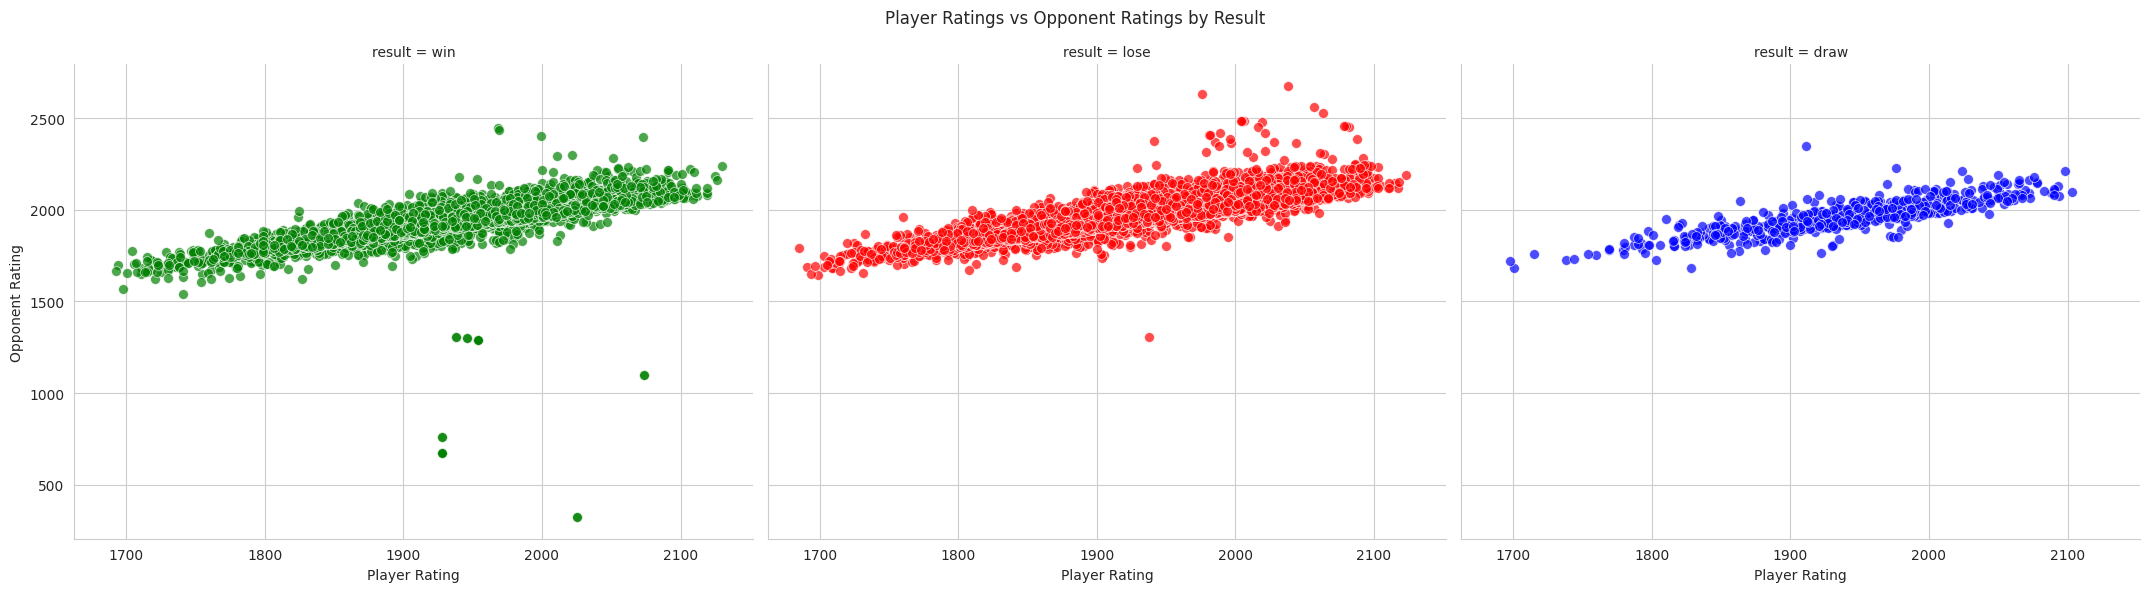

In [147]:
# Set the style of the plot
sns.set_style('whitegrid')

# Define the desired color palette
color_palette = {'win': 'green', 'lose': 'red', 'draw': 'blue'}

# Create a FacetGrid with 'result' as the column variable
g = sns.FacetGrid(df, col='result', hue='result', palette=color_palette, height=6, aspect=1.2)

# Map scatter plots to the grid, color-coded by 'result'
g.map(sns.scatterplot, 'player_rating', 'opponent_rating', s=50, alpha=0.7)

# Set the axis labels and title for each subplot
g.set_axis_labels('Player Rating', 'Opponent Rating')

# Set the title for the whole plot
g.fig.suptitle('Player Ratings vs Opponent Ratings by Result')

# Adjust the spacing between subplots
g.fig.tight_layout()

# Display the plot
plt.show()

<ipython-input-152-5451ac9686d1>:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ratings_by_year_month = df.groupby('year_month').mean()


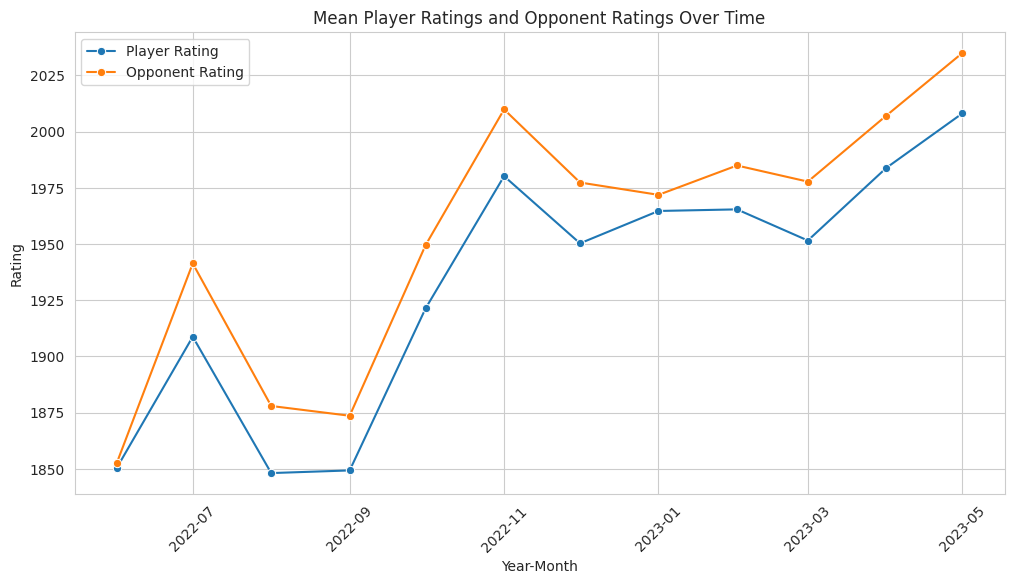

In [152]:

# Set the style of the plot
sns.set_style('whitegrid')

# Combine 'year' and 'month' columns to create a new column 'year_month'
df['year_month'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# Aggregate ratings by year and month and calculate the mean
ratings_by_year_month = df.groupby('year_month').mean()

# Sort the DataFrame by 'year_month'
ratings_by_year_month = ratings_by_year_month.sort_values('year_month')

# Create a line plot for player ratings over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=ratings_by_year_month['player_rating'], marker='o', markersize=6, label='Player Rating')

# Create a line plot for opponent ratings over time
sns.lineplot(data=ratings_by_year_month['opponent_rating'], marker='o', markersize=6, label='Opponent Rating')

# Set the title and labels
plt.title('Mean Player Ratings and Opponent Ratings Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Rating')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Display the legend
plt.legend()

# Display the plot
plt.show()

# Games over Time Analysis

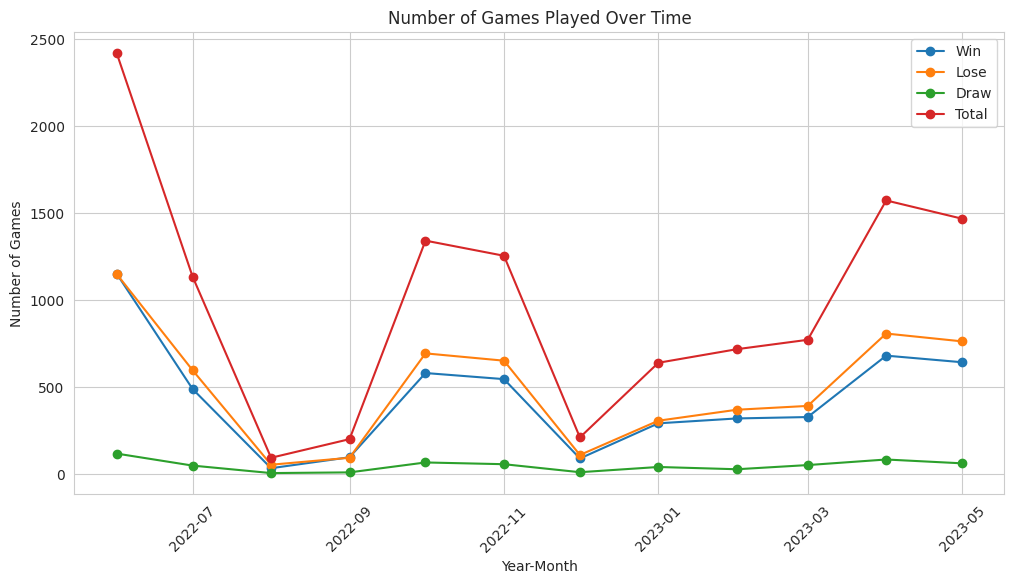

In [157]:
# Set the style of the plot
sns.set_style('whitegrid')

# Create a column for the combined year and month
df['year_month'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# Group the data by the year_month column and count the number of games played in each period
games_count = df.groupby(['year_month', 'result']).size().unstack(fill_value=0)

# Calculate the total number of games played regardless of outcome
games_count['total'] = games_count.sum(axis=1)

# Plot the line chart
plt.figure(figsize=(12, 6))

# Iterate over each outcome and plot a line for it
for outcome in ['win', 'lose', 'draw']:
    plt.plot(games_count.index, games_count[outcome], marker='o', label=outcome.capitalize())

# Plot a line for the total number of games
plt.plot(games_count.index, games_count['total'], marker='o', label='Total')

# Set the title and labels
plt.title('Number of Games Played Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Games')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Display the legend
plt.legend()

# Display the plot
plt.show()

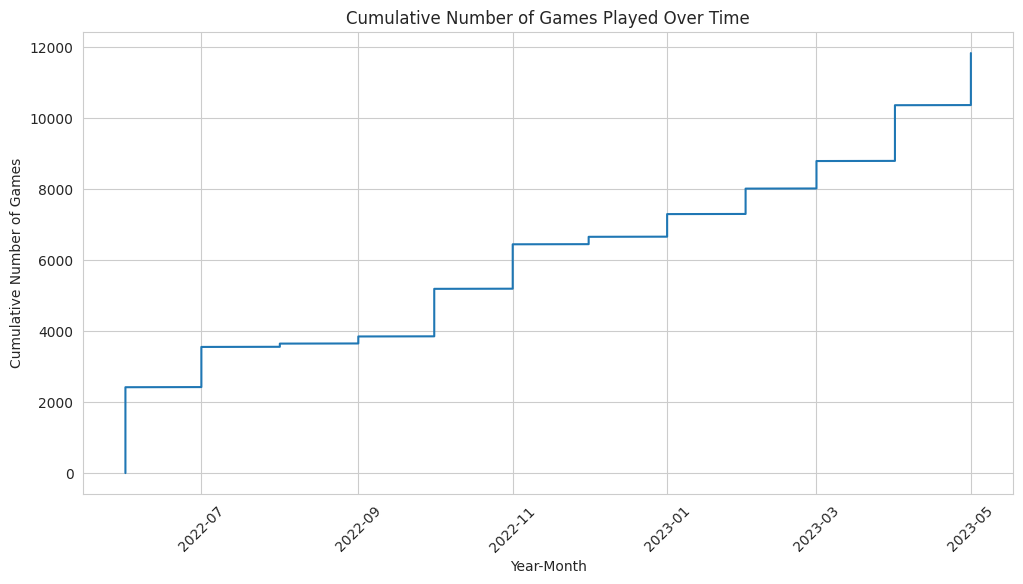

In [159]:

# Set the style of the plot
sns.set_style('whitegrid')

# Create a column for the combined year and month
df['year_month'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# Calculate the cumulative sum of the number of games played
df['cumulative_games'] = df.index + 1

# Plot the line chart
plt.figure(figsize=(12, 6))

# Plot the cumulative total line with connected points
plt.plot(df['year_month'], df['cumulative_games'])

# Set the title and labels
plt.title('Cumulative Number of Games Played Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Cumulative Number of Games')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Display the plot
plt.show()

# Time of Day Analysis

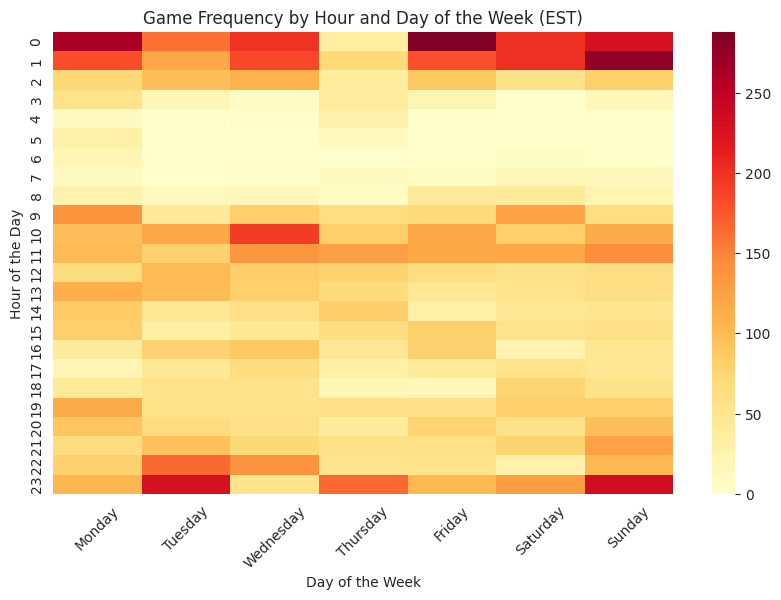

In [172]:
import pytz

# Assuming you have a DataFrame called df with 'year', 'month', 'day', 'hour', and 'minute' columns

# Combine the year, month, day, hour, and minute columns to create a datetime column
df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute']])

# Define the UTC time zone
utc_tz = pytz.timezone('UTC')

# Localize the datetime column to the UTC time zone
df['date'] = df['date'].dt.tz_localize('UTC')

# Define the Eastern Standard Time (EST) time zone
est_tz = pytz.timezone('US/Eastern')

# Convert the datetime column from UTC to EST
df['date_est'] = df['date'].apply(lambda x: x.astimezone(est_tz))

# Extract the hour and day of the week from the adjusted EST timestamps
df['hour_est'] = df['date_est'].dt.hour
df['day_of_week_est'] = df['date_est'].dt.day_name()

# Create a pivot table to calculate the count of games for each hour and day of the week combination
games_count = df.pivot_table(index='hour_est', columns='day_of_week_est', values='result', aggfunc='count', fill_value=0)

# Define the days of the week for proper ordering
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(games_count, cmap='YlOrRd', xticklabels=days_of_week, yticklabels=True)

# Set the title and labels
plt.title('Game Frequency by Hour and Day of the Week (EST)')
plt.xlabel('Day of the Week')
plt.ylabel('Hour of the Day')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Display the plot
plt.show()

<Figure size 1000x600 with 0 Axes>

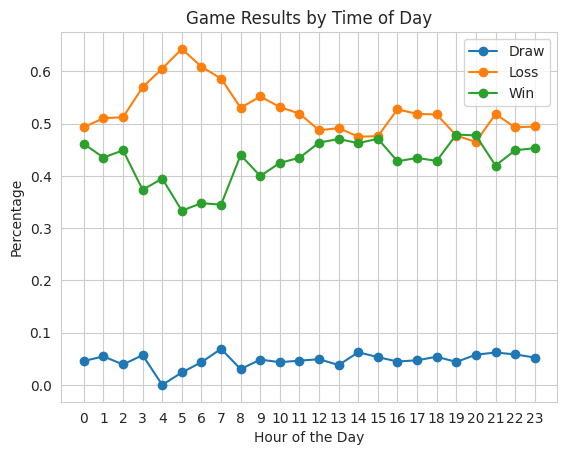

In [173]:
# Group the data by hour_est and calculate the count of games and the percentage of each result
result_stats = df.groupby('hour_est')['result'].value_counts(normalize=True).unstack().fillna(0)

# Plot the line chart
plt.figure(figsize=(10, 6))
result_stats.plot(kind='line', marker='o')

# Set the title and labels
plt.title('Game Results by Time of Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Percentage')

# Set the legend
plt.legend(['Draw', 'Loss', 'Win'])

# Set the x-axis ticks
plt.xticks(df['hour_est'].unique())

# Display the plot
plt.show()

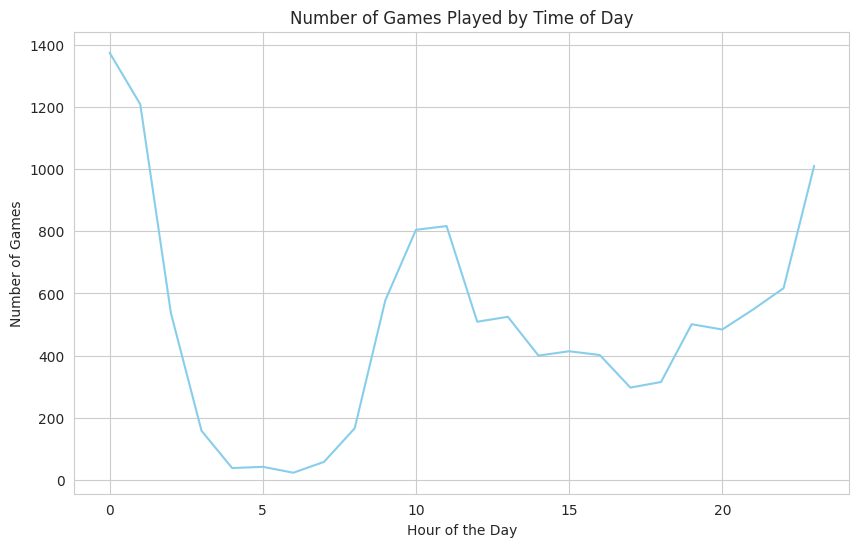

In [193]:

# Group the data by hour_est and calculate the count of games
games_count = df.groupby('hour_est').size().reset_index(name='count')

# Plot the area chart using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=games_count, x='hour_est', y='count', color='skyblue')

# Set the title and labels
plt.title('Number of Games Played by Time of Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Games')

# Display the plot
plt.show()


<Figure size 2000x1000 with 0 Axes>

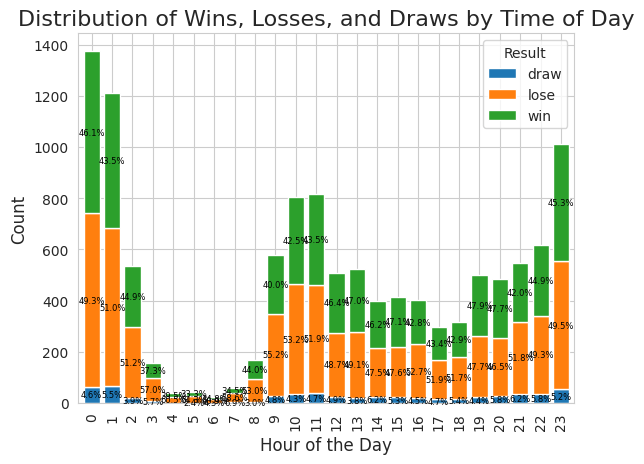

In [197]:

# Group the data by hour_est and result, and calculate the count of each result
result_counts = df.groupby(['hour_est', 'result']).size().unstack().fillna(0)

# Calculate the percentage of each result category at each hour
result_percentages = result_counts.apply(lambda x: x / x.sum(), axis=1) * 100

# Set the width of the bars
bar_width = 0.8

plt.figure(figsize=(20,10)) 

# Plot the stacked bar chart using Seaborn
ax = result_counts.plot(kind='bar', stacked=True, width=bar_width)

# Add percentages to the plot
for i, val in enumerate(result_counts.values):
    total = val.sum()
    for j, count in enumerate(val):
        percentage = result_percentages.values[i][j]
        if count > 0:
            ax.text(i, val[:j].sum() + count / 2, f'{percentage:.1f}%', ha='center', va='center', color='black', fontsize=6)

# Set the title and labels
plt.title('Distribution of Wins, Losses, and Draws by Time of Day', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Result')

# # Adjust the x-axis limits
# plt.xlim(-0.5, len(result_counts) - 0.5)

# Display the plot
plt.show()


# Takeaways




1.   Some of my Best Openings as WHITE (by Percentage):
Philidor, Pirc, King's Pawn, French


2.   Some of my Worst Openings as WHITE (by Percentage): Scandanavian, Sicilian, Caro-Kann


3.   Some of my Best Openings as BLACK (by Percentage):
Nimzowitsch, King's Pawn, Center Game


4.   Some of my Worst Openings as BLACK (by Percentage): Queens Pawn, Queens Gambit

5.  Most Frequent time to play is around midnight or 10 AM. Barely ever play from 4-7 AM

6. My Winning Percentages at night (12-1) are stronger than in the morning (9-10)

